In [1]:
#Importing Libraries

import fcsparser as fcsp
import re
import os
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, normalize, LabelEncoder, MinMaxScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV, ParameterGrid, train_test_split, RepeatedStratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score, accuracy_score, mean_squared_error, confusion_matrix
from sklearn.decomposition import PCA


import random

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [4]:
# Importing data

def load_data(dir):
    print('---- loading data ---->')
    data = {}
    for dirname, _, filename in os.walk(dir):
        for file in filename:
            path = os.path.join(dirname, file)
            # Slicing in order to remove .fcs from filename
            f_name = ''.join(list(file)[:-4])
            data[f_name] = pd.DataFrame(fcsp.parse(path, meta_data_only=False, reformat_meta=True)[1])
    return data, fcsp.parse(path, meta_data_only=False, reformat_meta=True)[0]['_channels_']
 

'''
for dirname, _, filename in os.walk(HERE):
    for file in filename:
      path = os.path.join()
        meta = fcsparser.parse(, meta_data_only=True, reformat_meta=True)
'''

def prepData(x,scaler=None):
        """
        Normalize data
        """
        if not scaler:
                scaler = StandardScaler().fit(x)
        x_transformed= np.nan_to_num(np.array(scaler.transform(x)))
        return normalize(x_transformed),scaler

# Loading fcs file data into a dictionary
global path

dir = os.path.abspath(os.path.dirname('C:\\Users\\ankit\\Downloads\\FCM Data\\FCM Data For Kartik - Copy\\spectinomycin'))
dir = os.path.join(dir, 'C:\\Users\\ankit\\Downloads\\FCM Data\\FCM Data For Kartik - Copy\\spectinomycin')
data, channels = load_data(dir)

# Function to return list of different taken samples
def sample_list(det = data):
    return set([sample[0:3] for sample in det.keys()])


# Function to check the dimensions of our fcs files
def checkDimensions(data, dimensions):
    for sample in data:
        if data[sample].shape != dimensions: print(sample, data[sample].shape)
    return 



---- loading data ---->


In [5]:
data

{'SHD1_1':              FSC-A   FSC-H         SSC-A       FITC-A         PE-A  \
 0       292.800018   686.0    776.160034   202.949997  -336.600006   
 1       440.000000   787.0   1234.530029   132.660004   -59.400002   
 2      1223.200073  1268.0    850.410034    50.490002   162.360001   
 3       760.000000   939.0    510.839996   -39.599998  -642.510010   
 4       451.200012   862.0    631.619995   -27.720001  -797.940002   
 ...            ...     ...           ...          ...          ...   
 99995  6126.399902  6598.0  11539.440430  1467.180054  2182.949951   
 99996   355.200012   915.0    994.950012    74.250000   -34.650002   
 99997   166.400009   759.0    607.859985  -109.889999   -66.330002   
 99998    99.200005   794.0    693.989990   111.870003  -314.820007   
 99999   132.000000   665.0    751.410034   -67.320000  -125.730003   
 
          PE-Cy5-A   PE-Cy7-A        APC-A   APC-Cy7-A  Pacific Blue-A  \
 0        3.960000 -42.570000   544.000000   84.000000      -3

In [6]:
checkDimensions(data,data[random.choice(list(data.keys()))].shape)

SHD1_2 (100021, 12)
SHD2_3 (99670, 12)


In [7]:
#concatenating the dataframes of all triplicates -->
def triplicates_combined(data = data):
    deta = {}
    for key in data.keys():
        deta[key[:4]]= pd.concat([data[key[:4]+'_1'],data[key[:4]+'_2'],data[key[:4]+'_3']],axis=0)
    return deta

triplicates_combined()


{'SHD1':              FSC-A   FSC-H        SSC-A      FITC-A        PE-A    PE-Cy5-A  \
 0       292.800018   686.0   776.160034  202.949997 -336.600006    3.960000   
 1       440.000000   787.0  1234.530029  132.660004  -59.400002  -46.529999   
 2      1223.200073  1268.0   850.410034   50.490002  162.360001  258.390015   
 3       760.000000   939.0   510.839996  -39.599998 -642.510010   20.790001   
 4       451.200012   862.0   631.619995  -27.720001 -797.940002  -45.540001   
 ...            ...     ...          ...         ...         ...         ...   
 99995   478.399994   860.0  1246.410034   98.010002  -82.169998   33.660000   
 99996   796.799988   915.0  1155.329956   86.129997 -518.760010    8.910000   
 99997   701.600037   802.0  1914.660034  -86.129997  728.640015  -45.540001   
 99998  5274.399902  4712.0  4514.399902   54.450001 -120.779999   17.820000   
 99999   428.800018   763.0   371.250000  120.779999 -236.610001   -6.930000   
 
         PE-Cy7-A       APC-A 

In [8]:
data.keys()

dict_keys(['SHD1_1', 'SHD1_2', 'SHD1_3', 'SHD2_1', 'SHD2_2', 'SHD2_3', 'SHD3_1', 'SHD3_2', 'SHD3_3', 'SHD4_1', 'SHD4_2', 'SHD4_3', 'SHD5_1', 'SHD5_2', 'SHD5_3', 'SLD1_1', 'SLD1_2', 'SLD1_3', 'SLD2_1', 'SLD2_2', 'SLD2_3', 'SLD3_1', 'SLD3_2', 'SLD3_3', 'SLD4_1', 'SLD4_2', 'SLD4_3', 'SLD5_1', 'SLD5_2', 'SLD5_3', 'SMD1_1', 'SMD1_2', 'SMD1_3', 'SMD2_1', 'SMD2_2', 'SMD2_3', 'SMD3_1', 'SMD3_2', 'SMD3_3', 'SMD4_1', 'SMD4_2', 'SMD4_3', 'SMD5_1', 'SMD5_2', 'SMD5_3'])

In [9]:
Day_1 = dict([(key,data[key]) for key in data.keys() if key.endswith('_1')])
Day_1.keys()

dict_keys(['SHD1_1', 'SHD2_1', 'SHD3_1', 'SHD4_1', 'SHD5_1', 'SLD1_1', 'SLD2_1', 'SLD3_1', 'SLD4_1', 'SLD5_1', 'SMD1_1', 'SMD2_1', 'SMD3_1', 'SMD4_1', 'SMD5_1'])

In [10]:
Day_1

{'SHD1_1':              FSC-A   FSC-H         SSC-A       FITC-A         PE-A  \
 0       292.800018   686.0    776.160034   202.949997  -336.600006   
 1       440.000000   787.0   1234.530029   132.660004   -59.400002   
 2      1223.200073  1268.0    850.410034    50.490002   162.360001   
 3       760.000000   939.0    510.839996   -39.599998  -642.510010   
 4       451.200012   862.0    631.619995   -27.720001  -797.940002   
 ...            ...     ...           ...          ...          ...   
 99995  6126.399902  6598.0  11539.440430  1467.180054  2182.949951   
 99996   355.200012   915.0    994.950012    74.250000   -34.650002   
 99997   166.400009   759.0    607.859985  -109.889999   -66.330002   
 99998    99.200005   794.0    693.989990   111.870003  -314.820007   
 99999   132.000000   665.0    751.410034   -67.320000  -125.730003   
 
          PE-Cy5-A   PE-Cy7-A        APC-A   APC-Cy7-A  Pacific Blue-A  \
 0        3.960000 -42.570000   544.000000   84.000000      -3

(1500000, 12)


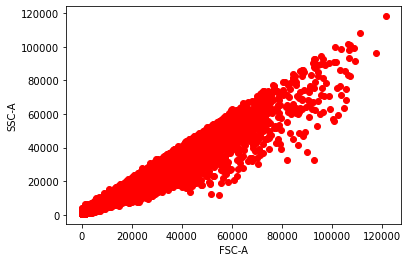

In [15]:
# function to plot combined data of all days(1-5) for a particular sample

def plot_sample(data, key):
    key = key[:3]
    original = pd.DataFrame()
    for day in range(1,6):
        l = pd.concat([data[key+str(day)+'_'+str(i)] for i in range(1,4)], axis = 0)
        original = pd.concat([original, l])
    plot = original
    print(plot.shape)
    plt.scatter(plot['FSC-A'],plot['FSC-H'], color = 'red')
    plt.xlabel('FSC-A')
    plt.ylabel('SSC-A')
    plt.show()

plot_sample(data,'SMD')

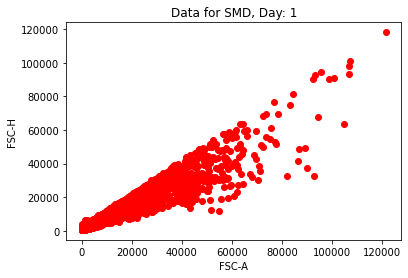

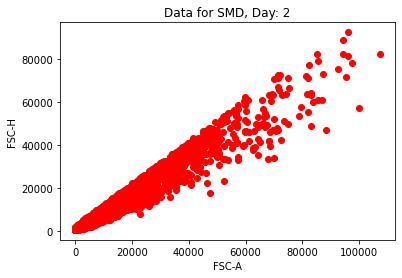

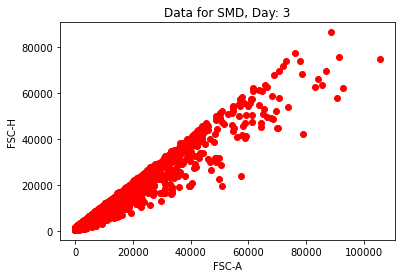

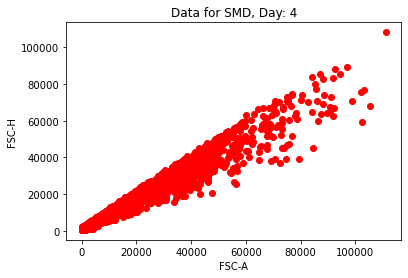

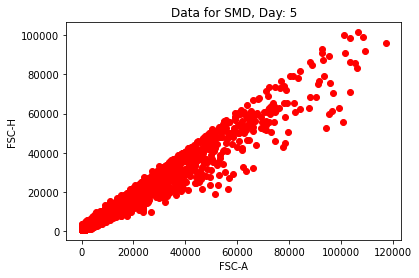

[None, None, None, None, None]

In [23]:
def plot_sample_data(data, key, day = 1):
    key = key[:3]
    plot = pd.concat([data[key+str(day)+'_'+str(i)] for i in range(1,4)])
    plt.scatter(plot['FSC-A'],plot['FSC-H'], color = 'red')
    plt.xlabel('FSC-A')
    plt.ylabel('FSC-H')
    plt.title(f'Data for {key}, Day: {day}')
    plt.show()
    

[plot_sample_data(data, 'SMD',i) for i in range(1,6)]

Cluster 1 Inertia 4401130373120.0
Cluster 2 Inertia 2335512199168.0
Cluster 3 Inertia 1730598273024.0
Cluster 4 Inertia 1358387871744.0
Cluster 5 Inertia 1077388902400.0
Cluster 6 Inertia 892162670592.0
Cluster 7 Inertia 761125339136.0
Cluster 8 Inertia 653377011712.0
Cluster 9 Inertia 583891222528.0
Cluster 10 Inertia 533624127488.0
Cluster 11 Inertia 486958399488.0
Cluster 12 Inertia 444415868928.0
Cluster 13 Inertia 416924827648.0
Cluster 14 Inertia 388647354368.0
Cluster 15 Inertia 368765730816.0
Cluster 16 Inertia 342003646464.0
Cluster 17 Inertia 326289883136.0
Cluster 18 Inertia 308874903552.0
Cluster 19 Inertia 297952673792.0


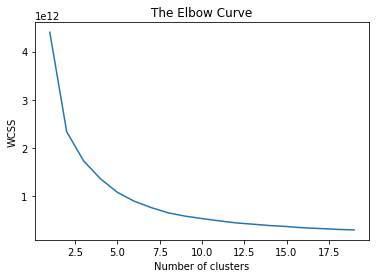

In [22]:
def elbow_curve(sample = sample):
    wcss = []
    for i in range(1,20):
      kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=0)
      kmeans.fit(sample)
      wcss.append(kmeans.inertia_)
      print('Cluster', i, 'Inertia', kmeans.inertia_,)
    plt.plot(range(1,20),wcss)
 
    plt.title('The Elbow Curve')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS') ##WCSS stands for total within-cluster sum of square
    plt.show()

elbow_curve()

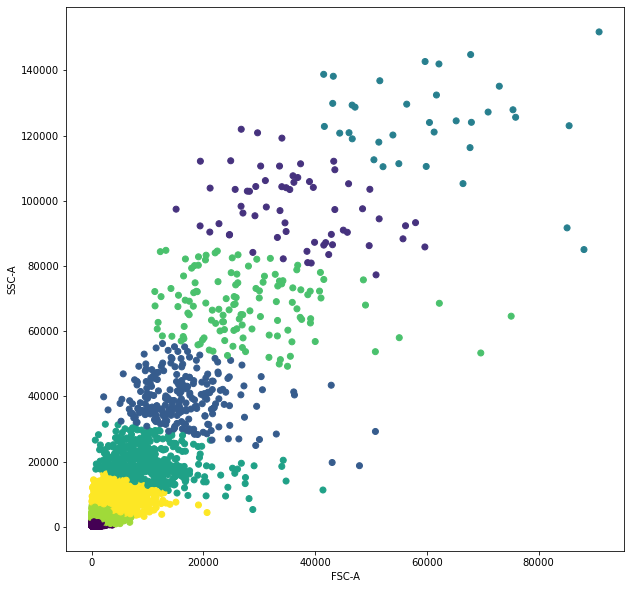

In [16]:
# Running Clustering with feature vector of size 3 in place of 3000 feature vector

num_clusters = 8
cols2 = random.choice(list(data.keys()))
sample = data[cols2][['FSC-A','SSC-A']]
kmean = KMeans(n_clusters = num_clusters).fit(sample)
kmean.predict(sample)
klabels = kmean.labels_

#filter rows of original data

cluster_count1 = np.zeros(num_clusters)
for cluster in range(num_clusters):
    filter_lb = sample[klabels == cluster]


fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111)
ax.scatter(sample['FSC-A'],sample['SSC-A'],c = klabels) 
plt.xlabel("FSC-A")
plt.ylabel("SSC-A")

plt.show()


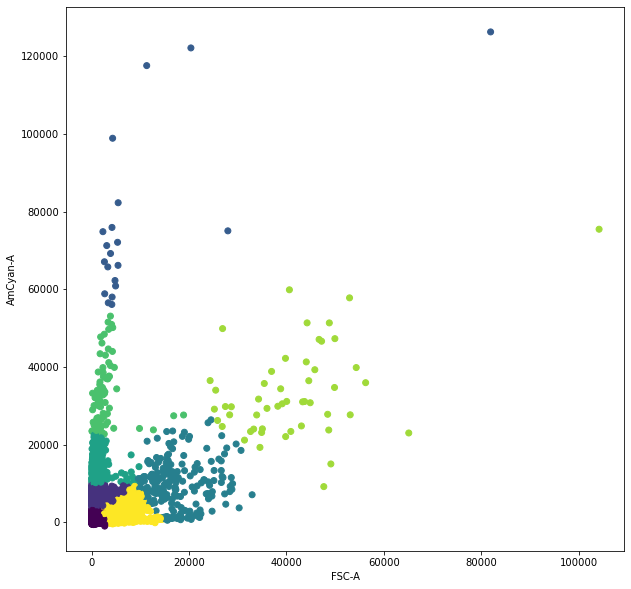

In [17]:
num_clusters = 8
cols2 = random.choice(list(data.keys()))
sample = data[cols2][['FSC-A','AmCyan-A']]
kmean = KMeans(n_clusters = num_clusters).fit(sample)
kmean.predict(sample)
klabels = kmean.labels_

#filter rows of original data

cluster_count1 = np.zeros(num_clusters)
for cluster in range(num_clusters):
    filter_lb = sample[klabels == cluster]


fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111)
ax.scatter(sample['FSC-A'],sample['AmCyan-A'],c = klabels) 
plt.xlabel("FSC-A")
plt.ylabel("AmCyan-A")
plt.show()

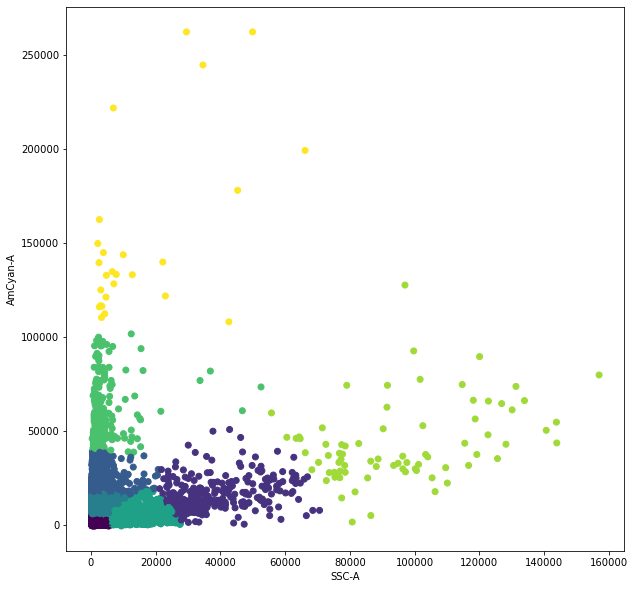

In [18]:
num_clusters = 8
cols2 = random.choice(list(data.keys()))
sample = data[cols2][['SSC-A','AmCyan-A']]
kmean = KMeans(n_clusters = num_clusters).fit(sample)
kmean.predict(sample)
klabels = kmean.labels_

#filter rows of original data

cluster_count1 = np.zeros(num_clusters)
for cluster in range(num_clusters):
    filter_lb = sample[klabels == cluster]


fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111)
ax.scatter(sample['SSC-A'],sample['AmCyan-A'],c = klabels) 
plt.xlabel("SSC-A")
plt.ylabel("AmCyan-A")
plt.show()

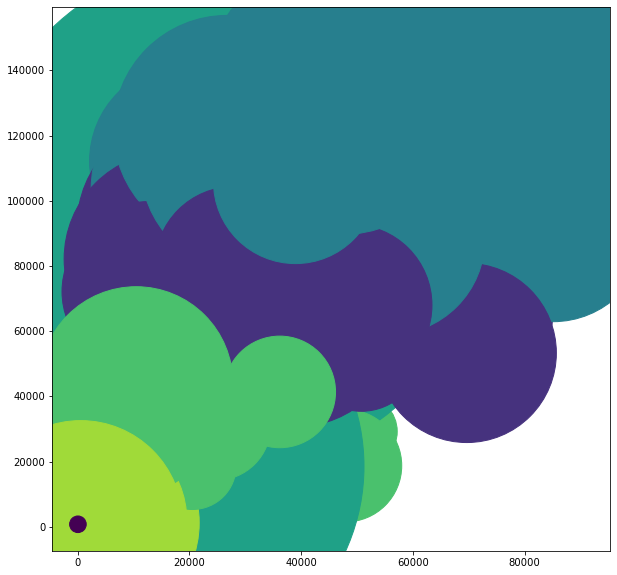

In [19]:
num_clusters = 8
cols2 = random.choice(list(data.keys()))
sample = data[cols2][['FSC-A','SSC-A','AmCyan-A']]
kmean = KMeans(n_clusters = num_clusters).fit(sample)
kmean.predict(sample)
klabels = kmean.labels_

#filter rows of original data

cluster_count1 = np.zeros(num_clusters)
for cluster in range(num_clusters):
    filter_lb = sample[klabels == cluster]


fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, )
ax.scatter(sample['FSC-A'],sample['SSC-A'],sample['AmCyan-A'],c = klabels) 

plt.show()

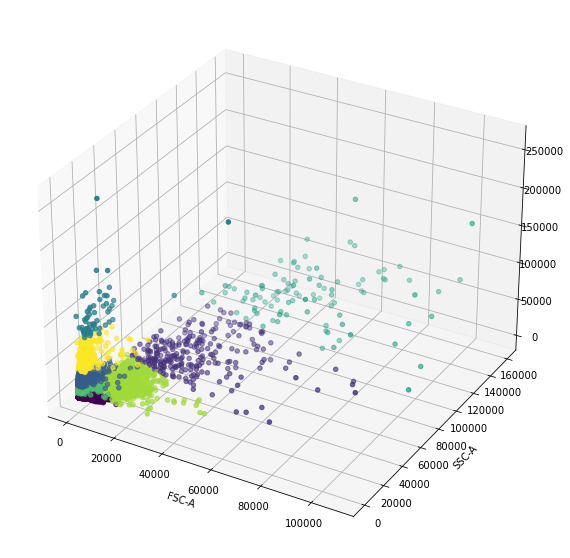

In [20]:
num_clusters = 8
cols2 = random.choice(list(data.keys()))
sample = data[cols2][['FSC-A','SSC-A','AmCyan-A']]
kmean = KMeans(n_clusters = num_clusters).fit(sample)
kmean.predict(sample)
klabels = kmean.labels_

#filter rows of original data

cluster_count1 = np.zeros(num_clusters)
for cluster in range(num_clusters):
    filter_lb = sample[klabels == cluster]


fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, projection='3d' )
ax.scatter(sample['FSC-A'],sample['SSC-A'],sample['AmCyan-A'],c = klabels) 
plt.xlabel("FSC-A", )
plt.ylabel("SSC-A",)

plt.show()

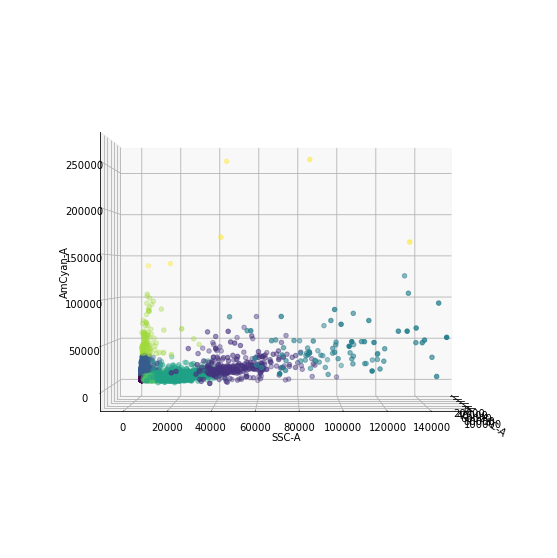

In [21]:
from mpl_toolkits import mplot3d
num_clusters = 8
cols2 = random.choice(list(data.keys()))
sample = data[cols2][['FSC-A','SSC-A','AmCyan-A']]
kmean = KMeans(n_clusters = num_clusters).fit(sample)
kmean.predict(sample)
klabels = kmean.labels_

#filter rows of original data

cluster_count1 = np.zeros(num_clusters)
for cluster in range(num_clusters):
    filter_lb = sample[klabels == cluster]


fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, projection='3d' )
ax.view_init(0,0 )
ax.scatter(sample['FSC-A'],sample['SSC-A'],sample['AmCyan-A'],c = klabels) 
plt.xlabel("FSC-A", )
plt.ylabel("SSC-A",)
ax.set_zlabel('AmCyan-A')


plt.show()